# Titanic: Machine Learning from Disaster KAGGLE


The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to Kaggle and go to the Titanic challenge to download train.csv and test.csv. Save them to the datasets/titanic directory.

Next, let's load the data:

In [130]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")


In [131]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [132]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [133]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<br>
<h5>The attributes have the following meaning:</h5>
<ul>
    <li><b>Survived:</b> that's the target, 0 means the passenger did not survive, while 1 means he/she survived.</li>
    <li><b>Pclass:</b> passenger class.</li>
    <li><b>Name, Sex, Age:</b> self-explanatory.</li>
    <li><b>SibSp:</b> how many siblings & spouses of the passenger aboard the Titanic.</li>
    <li><b>Parch:</b> how many children & parents of the passenger aboard the Titanic.</li>
    <li><b>Ticket:</b> ticket id.</li>
    <li><b>Fare:</b> price paid (in pounds).</li>
    <li><b>Cabin:</b> passenger's cabin number.</li>
    <li><b>Embarked:</b> where the passenger embarked the Titanic.</li>
</ul>

<br>

In [134]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<br>

Okay, the Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:



<br>
<br>


In [135]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<br>


<li>Yikes, only 38% Survived. :( Thats close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.</li>
<li>The mean Fare was £32.20, which does not seem so expensive (but it was probably a lot of money back then).</li>
<li>The mean Age was less than 30 years old.</li>


Let's check that the target is indeed 0 or 1:

<br>

In [136]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [137]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [138]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [139]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<br>
<br>


The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Note: the code below uses a mix of Pipeline, FeatureUnion and a custom DataFrameSelector to preprocess some columns differently. Since Scikit-Learn 0.20, it is preferable to use a ColumnTransformer, like in the previous chapter.

Now let's build our preprocessing pipelines. We will reuse the DataframeSelector we built in the previous chapter to select specific attributes from the DataFrame:

<br>
<br>

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        #("select_numeric", DataFrameSelector(["AgeBucket", "RelativesOnboard", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [142]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

<br>


We will also need an imputer for the string categorical columns (the regular SimpleImputer does not work on those):
    
<br>

In [143]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [144]:
from sklearn.preprocessing import OneHotEncoder

<br>
Now we can build the pipeline for the categorical attributes:

<br>

In [145]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [146]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines:

In [147]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [148]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [149]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an SVC:

In [150]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Great, our model is trained, let's use it to make predictions on the test set:

In [113]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [114]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the leaderboard for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the list of victims of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a RandomForestClassifier:

In [115]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forset_model=forest_clf.fit(X_train, y_train)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

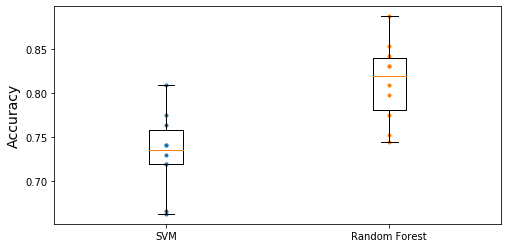

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:


<ul>
<li>Compare many more models and tune hyperparameters using cross validation and grid search,</li>
<li>Do more feature engineering, for example:</li>
 <ul>  
    <li>replace SibSp and Parch with their sum,</li>
    <li>try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely),</li>
    </ul>

    
<li>try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).</li>
    </ul>

In [124]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

test_data["AgeBucket"] = test_data["Age"] // 15 * 15


In [125]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()


test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]
# test_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

In [119]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,15.0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,15.0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,15.0,0


In [120]:
num_pipeline = Pipeline([
        #("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("select_numeric", DataFrameSelector(["AgeBucket", "RelativesOnboard", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])


cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [62. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [28. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [28. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

In [151]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_test=preprocess_pipeline.fit_transform(test_data)

In [127]:
test_data

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [152]:
# preds=forset_model.predict(X_test)

In [46]:
submission = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':preds})

In [47]:
submission.to_csv('submission.csv', index=False)

# Trying with LightGBM

In [198]:
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter



# dtrain = lgb.Dataset(train[feature_cols], label=train['Stay'])
# dvalid = lgb.Dataset(valid[feature_cols], label=valid['Stay'])

#param = {'num_leaves': 64, 'objective': 'multiclass'}
params = {}
params['learning_rate'] = 0.05
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'binary'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.62, 1: 0.38}



clf = lgb.LGBMClassifier()


lightgbm_scores = cross_val_score(clf, X_train, y_train, cv=10)
# clf.fit(train[feature_cols], train['Stay'], early_stopping_rounds=100, eval_set=[(valid[feature_cols], valid['Stay']),
#         (test[feature_cols], test['Stay'])], eval_metric='multi_error', verbose=True)

# eval_score = accuracy_score(test['Stay'], clf.predict(test[feature_cols]))

# print('Eval ACC: {}'.format(eval_score))

lightgbm_scores

array([0.76666667, 0.82022472, 0.73033708, 0.83146067, 0.87640449,
       0.85393258, 0.86516854, 0.74157303, 0.85393258, 0.85393258])

In [199]:
valid_fraction = 0.20
valid_size = int(len(X_train) * valid_fraction)

train = X_train[:-2 * valid_size]
valid = X_train[-2 * valid_size:-valid_size]
test = X_train[-valid_size:]


train_lb = y_train[:-2 * valid_size]
valid_lb = y_train[-2 * valid_size:-valid_size]
test_lb = y_train[-valid_size:]

In [200]:
clf.fit(train, train_lb, early_stopping_rounds=100, eval_set=[(valid, valid_lb),
        (test, test_lb)], eval_metric='multi_error', verbose=True)



eval_score = accuracy_score(test_lb, clf.predict(test))

print('Eval ACC: {}'.format(eval_score))

[1]	valid_0's binary_error: 0.404494	valid_0's binary_logloss: 0.639516	valid_1's binary_error: 0.353933	valid_1's binary_logloss: 0.607577
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.382022	valid_0's binary_logloss: 0.610863	valid_1's binary_error: 0.325843	valid_1's binary_logloss: 0.571173
[3]	valid_0's binary_error: 0.230337	valid_0's binary_logloss: 0.589127	valid_1's binary_error: 0.185393	valid_1's binary_logloss: 0.54245
[4]	valid_0's binary_error: 0.224719	valid_0's binary_logloss: 0.570303	valid_1's binary_error: 0.168539	valid_1's binary_logloss: 0.517847
[5]	valid_0's binary_error: 0.224719	valid_0's binary_logloss: 0.555746	valid_1's binary_error: 0.168539	valid_1's binary_logloss: 0.498767
[6]	valid_0's binary_error: 0.230337	valid_0's binary_logloss: 0.540959	valid_1's binary_error: 0.168539	valid_1's binary_logloss: 0.478768
[7]	valid_0's binary_error: 0.224719	valid_0's binary_logloss: 0.532146	valid_1's binary_error: 0.1

In [201]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)


clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train, eval_metric='multi_error', verbose=False)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(y_train, clf.predict(X_train))

print('ACC: {}'.format(eval_score_acc))

{'learning_rate': 0.05, 'max_depth': 18, 'n_estimators': 26, 'objective': 'binary', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}
ACC: 0.8092031425364759


In [202]:
preds=clf.predict(X_test)



In [203]:
submission = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':preds})

In [204]:
submission.to_csv('submission.csv', index=False)

# Trying with XGBOOST

In [72]:
import xgboost

from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score




# Define the model
my_model_3 = XGBRegressor(n_estimators=1000, learning_rate=0.15)

# Fit the model
my_model_3.fit(train, train_lb,
             early_stopping_rounds=5,
               eval_set=[(valid, valid_lb),
        (test, test_lb)],
             verbose=False) # Your code here

# Get predictions
#predictions_3 = my_model_3.predict(X_valid)

eval_score = accuracy_score(test_lb, my_model_3.predict(test))

print('Eval ACC: {}'.format(eval_score))

ValueError: Classification metrics can't handle a mix of binary and continuous targets